In [1]:
import sys; sys.path.append('../')
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import OrderedDict
from loss import compare_activations, get_bre_loss, get_gradmask_loss
import copy
import itertools
import logging
import notebooks.auto_ipynb as auto_ipynb
import numpy as np
import pprint
import random
import time, os, sys
import torch
import torch.nn as nn
import utils.configuration as configuration
import utils.monitoring as monitoring
import models, models.CNN, models.ResNetSmall, models.UNet
import matplotlib.pyplot as plt
from datasets.MSDDataset import MSDDataset
from datasets.XRay import JointDataset as XRayDataset
import glob

In [2]:
def render_img(text, i, sample, models_list, exp_name):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=6,
                                             figsize=(18, 12), dpi=72)
    x, target, use_mask = sample
    #x = torch.tensor(x)
    x_var = torch.autograd.Variable(x[0].unsqueeze(0),
        requires_grad=True).float()

#     if torch.cuda.is_available(): 
#         x_var = x_var.cuda()
#         cnn = cnn.cuda()
#         resnet = resnet.cuda()
#         unet = unet.cuda()

    ax0.set_title(str(i) + " Masked Image")
    img = x[0][0].cpu().numpy()
    img = img / np.max(img)  # Scales the input image so that the maximum=1.
    seg = x[1][0].cpu().numpy() #* 0.5  # Makes mask bright, but not too bright.
    ax0.imshow(img+seg, interpolation='none', cmap='Greys_r')
    ax0.axis('off')
    
    ax1.set_title("Mask")
    ax1.imshow(1-seg, cmap="Greys_r", interpolation='none')
    ax1.axis('off')

    ax2.set_title(models_list[0][0])
    this_model = models_list[0][1]
    
    print(x_var.shape)
    
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax2.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax2.axis('off')
    
    ax3.set_title(models_list[1][0])
    this_model = models_list[1][1]
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax3.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax3.axis('off')
    
    ax4.set_title(models_list[2][0])
    this_model = models_list[2][1]
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax4.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax4.axis('off')

    ax5.set_title("UNet Reconstruction")
    # Fails for models that output a nonsense reconstruction (CNN, ResNet).
    if isinstance(x_prime, torch.Tensor):
        ax5.imshow(x_prime[0][0].detach().cpu().numpy(),
                   interpolation='none', cmap='Greys_r')
        ax5.axis('off')
    else:
        ax5.remove()

    plt.tight_layout()
    plt.show()

In [3]:
args = {'d1data': '/lustre04/scratch/cohenjos/NIH/images-128', 
        'd1csv': '/lustre03/project/6008064/jpcohen/ChestXray-NIHCC/Data_Entry_2017.csv', 
        'd2data': '/lustre04/scratch/cohenjos/PC/images-128', 
        'd2csv': '/lustre03/project/6008064/jpcohen/PADCHEST_SJ/labels_csv/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv', 
        'ratio': 0.9,
        'mode': 'test',
        'seed': 1234,
        'new_size': 128}

d = XRayDataset(**args)

/home/jdv/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


n_per_category=500
TRAIN: neg=499, pos=499
VALID: neg=249, pos=249
TEST: neg=252, pos=252


In [5]:
glob.glob("/home/jdv/code/activmask/activmask/checkpoints/*/*.tar")

['/home/jdv/code/activmask/activmask/checkpoints/xray_resnet/latest_model_1234_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet/best_model_1234_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet_actdiff/latest_model_1234_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet_actdiff/best_model_1234_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet_gradmask/latest_model_1234_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet_gradmask/best_model_1234_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet_maskedall/best_model_1234_1.0.pth.tar',
 '/home/jdv/code/activmask/activmask/checkpoints/xray_resnet_maskedall/latest_model_1234_1.0.pth.tar']

In [ ]:
glob.glob("/home/cohenjos/workspace/activmask/activmask/checkpoints/*/*.tar")

In [ ]:
# a= torch.load("/home/cohenjos/workspace/activmask/activmask/checkpoints/xray_resnet/best_model_0_1.0.pth.tar", map_location='cpu')
# resnet = models.ResNetSmall.ResNetBig(base_size=25088)
# resnet.load_state_dict(a.state_dict())

In [ ]:
# a= torch.load("/home/cohenjos/workspace/activmask/activmask/checkpoints/xray_resnet_gradmask/best_model_0_1.0.pth.tar", map_location='cpu')
# gradmask = models.ResNetSmall.ResNetBig(base_size=25088)
# gradmask.load_state_dict(a.state_dict())

In [9]:
models_names_list = ["xray_resnet/best","xray_resnet_actdiff/best","xray_resnet_gradmask/best"]
models_list = []
for m in models_names_list:
    a= torch.load("/home/jdv/code/activmask/activmask/checkpoints/{}_model_1234_1.0.pth.tar".format(m), map_location='cpu')
    #a= torch.load("/home/cohenjos/workspace/activmask/activmask/checkpoints/{}_model_0_1.0.pth.tar".format(m), map_location='cpu')
    resnet = models.ResNetSmall.ResNetSmall(base_size=8192, img_size=128)
    resnet.load_state_dict(a.state_dict())
    models_list.append([m,resnet])
    

1.0
torch.Size([1, 1, 128, 128])


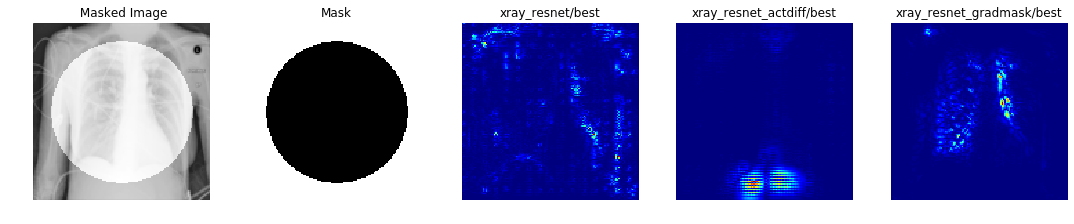

In [10]:
sample = d[10]
print(sample[2])
render_img("test", "", sample, models_list, "a")

In [ ]:
resnet = models.ResNetSmall.ResNetBig(base_size=61952, img_size=112)

In [ ]:
resnet(torch.ones([1,1,300,300]))

In [ ]:
plt.imshow(new_img)

In [ ]:
#torch.tensor(d[546][0])[1].shape

In [ ]:
# x, target, use_mask = sample
# x = torch.tensor(x[0])
# x_var = torch.autograd.Variable(x.unsqueeze(0),
#     requires_grad=True)

# y_prime, x_prime = resnet(x_var)
# gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
#                              "contrast").detach().cpu().numpy()[0][0]

In [ ]:
aa = []
for i in np.where(d.labels == 0)[0]:
    #print(d[i][0][0].mean(0).shape)
    
    x, target, use_mask = d[i]
    x = torch.tensor(x[0])
    x_var = torch.autograd.Variable(x.unsqueeze(0),
        requires_grad=True)
    
    if torch.cuda.is_available():
        x_var = x_var.cuda()
        resnet = resnet.cuda()

    y_prime, x_prime = resnet(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    
    aa.append(gradmask)

In [ ]:
bb = []
for i in np.where(d.labels == 1)[0]:
    #print(d[i][0][0].mean(0).shape)
    
    x, target, use_mask = d[i]
    x = torch.tensor(x[0])
    x_var = torch.autograd.Variable(x.unsqueeze(0),
        requires_grad=True)
    
    if torch.cuda.is_available():
        x_var = x_var.cuda()
        resnet = resnet.cuda()

    y_prime, x_prime = resnet(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    
    bb.append(gradmask)

In [ ]:
m1 = np.abs(np.asarray(aa)).mean(0)
plt.imshow(m1);

In [ ]:
m2 = np.abs(np.asarray(bb)).mean(0)
plt.imshow(m2);